<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center> Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 4.  Сравнение алгоритмов классификации

Теперь мы наконец подойдем к обучению моделей классификации, сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (*session_length* и *window_size*) лучше использовать. Также для выбранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

**План 4 недели:**
- Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов
- Часть 2. Выбор параметров – длины сессии и ширины окна
- Часть 3. Идентификация  конкретного пользователя и кривые обучения
 


**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Линейная классификация](https://www.coursera.org/learn/supervised-learning/lecture/jqLcO/linieinaia-klassifikatsiia)
   - [Сравнение алгоритмов и выбор гиперпараметров](https://www.coursera.org/learn/supervised-learning/lecture/aF79U/sravnieniie-alghoritmov-i-vybor-ghipierparamietrov)
   - [Кросс-валидация. Sklearn.cross_validation](https://www.coursera.org/learn/supervised-learning/lecture/XbHEk/kross-validatsiia-sklearn-cross-validation)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   - и многие другие


<font color='red'>**Задание:**</font> заполните код в этой тетрадке и выберите ответы в [веб-форме](https://docs.google.com/forms/d/12VB7kmzDoSVzSpQNaJp0tR-2t8K8PynQopP3dypf7i4). 

In [1]:
# pip install watermark
%load_ext watermark

In [2]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

CPython 3.6.1
IPython 5.3.0

numpy 1.12.1
scipy 0.19.0
pandas 0.20.1
matplotlib 2.0.2
statsmodels 0.8.0
sklearn 0.18.1

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 58 Stepping 9, GenuineIntel
CPU cores  : 8
interpreter: 64bit
Git hash   : c27c232401baa7eb45da230c27a2983b59cd7136


In [2]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

CPython 3.6.1
IPython 5.3.0

numpy 1.13.3
scipy 0.19.0
pandas 0.20.1
matplotlib 2.1.0
statsmodels 0.8.0
sklearn 0.19.0

compiler   : GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)
system     : Darwin
release    : 16.7.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit
Git hash   : ca8e6e4e47061a4c44a8506c9741b1c65fc9249a


In [3]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from time import time
import itertools
import os
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import pickle
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

In [4]:
# Поменяйте на свой путь к данным
#PATH_TO_DATA = '~/capstone_user_identification'
PATH_TO_DATA = 'data/capstone_user_identification'

## Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов

**Загрузим сериализованные ранее объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей выборке для 10 пользователей.**

In [5]:
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

**Здесь более 14 тысяч сессий и почти 5 тысяч уникальных посещенных сайтов.**

In [6]:
X_sparse_10users.shape

(14061, 4913)

In [4]:
X_sparse_10users.shape

(14061, 4913)

**Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17 – для воспроизводимости.**

In [8]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).**

In [9]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

**1. Обучите `KNeighborsClassifier` со 100 ближайшими соседями (остальные параметры оставьте по умолчанию, только `n_jobs`=-1 для распараллеливания) и посмотрите на долю правильных ответов на 3-кратной кросс-валидации (ради воспроизводимости используйте для этого объект `StratifiedKFold` `skf`) по выборке `(X_train, y_train)` и отдельно на выборке `(X_valid, y_valid)`.**

In [10]:
from sklearn.neighbors import KNeighborsClassifier

In [26]:
''' ВАШ КОД ЗДЕСЬ '''
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)
knn = KNeighborsClassifier(n_neighbors=100, n_jobs=-1)
cv_train = cross_val_score(knn, X_train, y_train, cv=skf, scoring='accuracy')
round(cv_train.mean(), 3)

0.56200000000000006

In [27]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)
knn = KNeighborsClassifier(n_neighbors=100, n_jobs=-1)
cv_valid = cross_val_score(knn, X_valid, y_valid, cv=skf, scoring='accuracy')
round(cv_valid.mean(), 3)

0.497

**<font color='red'>Вопрос 1. </font> Посчитайте доли правильных ответов для KNeighborsClassifier на кросс-валидации и отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [30]:
''' ВАШ КОД ЗДЕСЬ '''
knn = KNeighborsClassifier(n_neighbors=100, n_jobs=-1)
round(accuracy_score(knn.fit(X_train, y_train).predict(X_valid), y_valid), 3)

0.58399999999999996

**2. Обучите случайный лес (`RandomForestClassifier`) из 100 деревьев (для воспроизводимости `random_state`=17). Посмотрите на OOB-оценку (для этого надо сразу установить `oob_score`=True) и на долю правильных ответов на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs`=-1.**

In [31]:
from sklearn.ensemble import RandomForestClassifier

In [33]:
''' ВАШ КОД ЗДЕСЬ '''
forest = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=17)
round(accuracy_score(forest.fit(X_train, y_train).predict(X_valid), y_valid), 3)

0.73499999999999999

**<font color='red'>Вопрос 2. </font> Посчитайте доли правильных ответов для `RandomForestClassifier` при Out-of-Bag оценке и на отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [133]:
# write_answer_to_file(''' ВАШ КОД ЗДЕСЬ ''',
#                      'answer4_2.txt')

round(forest.oob_score_, 3), round(accuracy_score(forest.fit(X_train, y_train).predict(X_valid), y_valid), 3)

(0.72299999999999998, 0.73499999999999999)

In [39]:
#!cat answer4_2.txt

**3. Обучите логистическую регрессию (`LogisticRegression`) с параметром `C` по умолчанию и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs=-1`.**

In [40]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [43]:
''' ВАШ КОД ЗДЕСЬ '''
logit = LogisticRegression(random_state=17)
cv = cross_val_score(logit, X_train, y_train, cv=skf, n_jobs=-1)
cv.mean()

0.76254867130480253

In [44]:
round(accuracy_score(logit.fit(X_train, y_train).predict(X_valid), y_valid), 3)

0.78200000000000003

**Почитайте документацию к [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Логистическая регрессия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации `C` (быстрее, чем с `GridSearchCV`).**

**С помощью `LogisticRegressionCV` подберите параметр `C` для `LogisticRegression` сначала в широком диапазоне: 10 значений от 1e-4 до 1e2, используйте `logspace` из `NumPy`. Укажите у `LogisticRegressionCV` параметры `multi_class`='multinomial' и `random_state`=17. Для кросс-валидации используйте объект `skf`, созданный ранее. Для распараллеливания задайте `n_jobs=-1`.**

**Нарисуйте кривые валидации по параметру `C`.**

In [45]:
%%time
logit_c_values1 = np.logspace(-4, 2, 10)

''' ВАШ КОД ЗДЕСЬ '''
logit_grid_searcher1 = LogisticRegressionCV(Cs=logit_c_values1, cv=skf, n_jobs=-1, multi_class='multinomial', random_state=17)
logit_grid_searcher1.fit(X_train, y_train)

Wall time: 37.1 s


Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [52]:
logit_grid_searcher1.scores_[31].mean(axis=0)

array([ 0.31679887,  0.47358573,  0.55476721,  0.64855051,  0.71550746,
        0.75005386,  0.76122877,  0.76224293,  0.75543568,  0.7458858 ])

In [65]:
''' ВАШ КОД ЗДЕСЬ '''
logit_mean_cv_scores1 = logit_grid_searcher1.scores_[31].mean(axis=0)

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [58]:
''' ВАШ КОД ЗДЕСЬ '''
print('score =', logit_mean_cv_scores1.max(), '\nC_maxscore =', logit_c_values1[logit_mean_cv_scores1.argmax()])

score = 0.762242926169 
C_maxscore = 4.64158883361


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

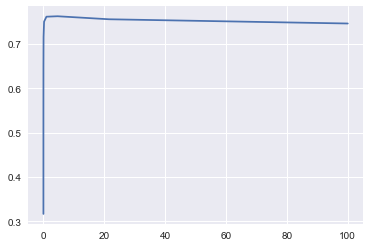

In [59]:
plt.plot(logit_c_values1, logit_mean_cv_scores1);

**Теперь то же самое, только значения параметра `C` перебирайте в диапазоне `np.linspace`(0.1, 7, 20). Опять нарисуйте кривые валидации, определите максимальное значение доли правильных ответов на кросс-валидации.**

In [68]:
%%time
logit_c_values2 = np.linspace(0.1, 7, 20)

''' ВАШ КОД ЗДЕСЬ '''
logit_grid_searcher2 = LogisticRegressionCV(Cs=logit_c_values2, cv=skf, n_jobs=-1, multi_class='multinomial', random_state=17)
logit_grid_searcher2.fit(X_train, y_train)

Wall time: 49.5 s


Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [69]:
''' ВАШ КОД ЗДЕСЬ '''
logit_mean_cv_scores2 = logit_grid_searcher2.scores_[31].mean(axis=0)
logit_mean_cv_scores2

array([ 0.73501462,  0.75645532,  0.76041517,  0.76254821,  0.76376787,
        0.76376645,  0.76386851,  0.76315759,  0.76336038,  0.76315781,
        0.76295338,  0.762649  ,  0.76285231,  0.7632594 ,  0.76244658,
        0.76153253,  0.76092333,  0.76031364,  0.76010968,  0.76000799])

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [70]:
''' ВАШ КОД ЗДЕСЬ '''
print('score =', logit_mean_cv_scores2.max(), '\nC_maxscore =', logit_c_values2[logit_mean_cv_scores2.argmax()])

score = 0.763868510339 
C_maxscore = 2.27894736842


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

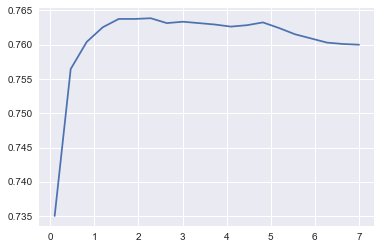

In [71]:
plt.plot(logit_c_values2, logit_mean_cv_scores2);

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для логистической регрессии с лучшим найденным значением `C`.

In [77]:
''' ВАШ КОД ЗДЕСЬ '''
logit.C = logit_c_values2[logit_mean_cv_scores2.argmax()]
logit_cv_acc = accuracy_score(logit.fit(X_train, y_train).predict(X_valid), y_valid)
logit_cv_acc

0.78383503199810378

**<font color='red'>Вопрос 3. </font>Посчитайте доли правильных ответов для `logit_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [141]:
''' ВАШ КОД ЗДЕСЬ '''
print('best_cv_score =', round(logit_mean_cv_scores2.max(), 3),
      '\nvalid_score =', round(accuracy_score(logit_grid_searcher2.fit(X_train, y_train).predict(X_valid), y_valid), 3))

best_cv_score = 0.764 
valid_score = 0.78


In [90]:
''' ВАШ КОД ЗДЕСЬ '''
print('best_cv_score =', round(logit_mean_cv_scores2.max(), 3),
      '\nvalid_score =', round(logit_grid_searcher2.score(X_valid, y_valid), 3))

best_cv_score = 0.764 
valid_score = 0.78


**4. Обучите линейный SVM (`LinearSVC`) с параметром `C`=1 и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`.**

In [91]:
from sklearn.svm import LinearSVC

In [92]:
''' ВАШ КОД ЗДЕСЬ '''
svm = LinearSVC(C=1, random_state=17)
cv = cross_val_score(svm, X_train, y_train, cv=skf, n_jobs=-1)
cv.mean()

0.75655369169304965

In [93]:
accuracy_score(svm.fit(X_train, y_train).predict(X_valid), y_valid)

0.77696136525242954

**С помощью `GridSearchCV` подберите параметр `C` для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [94]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

''' ВАШ КОД ЗДЕСЬ '''
svm_grid_searcher1 = GridSearchCV(svm, param_grid=svm_params1)
svm_grid_searcher1.fit(X_train, y_train)

Wall time: 56.8 s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [95]:
''' ВАШ КОД ЗДЕСЬ '''
svm_grid_searcher1.best_score_, svm_grid_searcher1.best_params_

(0.69223735013208698, {'C': 3333.3334000000004})

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

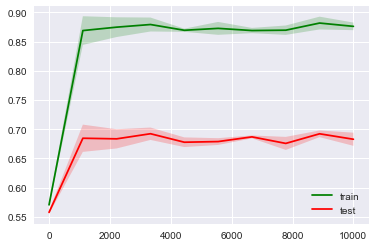

In [96]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

**Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений `C`). Здесь намного осмысленней подбирать `C` в районе 1, к тому же, так модель быстрее обучается, чем при больших `C`. **

**С помощью `GridSearchCV` подберите параметр `C` для SVM в диапазоне (1e-3, 1), 30 значений, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [134]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

''' ВАШ КОД ЗДЕСЬ '''
svm = LinearSVC(C=1, random_state=17)
svm_grid_searcher2 = GridSearchCV(svm, param_grid=svm_params2)
svm_grid_searcher2.fit(X_train, y_train)

Wall time: 1min 41s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [135]:
''' ВАШ КОД ЗДЕСЬ '''
svm_grid_searcher2.best_score_ , svm_grid_searcher2.best_params_

(0.76610445031497665, {'C': 0.13879310344827586})

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

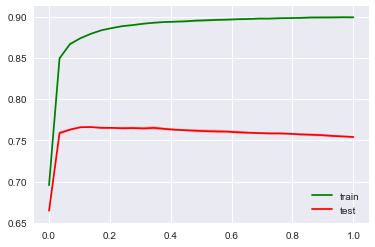

In [136]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для `LinearSVC` с лучшим найденным значением `C`.

In [137]:
''' ВАШ КОД ЗДЕСЬ '''
svm.C = svm_grid_searcher2.best_params_['C']
svm_cv_acc = accuracy_score(svm.fit(X_train, y_train).predict(X_valid), y_valid)
svm_cv_acc

0.78170182507703245

**<font color='red'>Вопрос 4. </font> Посчитайте доли правильных ответов для `svm_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [138]:
''' ВАШ КОД ЗДЕСЬ '''
svm_grid_searcher2.best_score_, \
accuracy_score(svm_grid_searcher2.best_estimator_.predict(X_valid), y_valid)

(0.76610445031497665, 0.78170182507703245)

## Часть 2. Выбор параметров – длины сессии и ширины окна

**Возьмем `LinearSVC`, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации `C`.**

**Определите функцию `model_assessment`, ее документация описана ниже. Обратите внимание на все детали. Например, на то, что разбиение  выборки с `train_test_split` должно быть стратифицированным. Не теряйте нигде `random_state`.**

In [125]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    
    ''' ВАШ КОД ЗДЕСЬ '''
    
    # Загрузим сериализованные ранее объекты X_sparse и y
    with open(path_to_X_pickle, 'rb') as X_sparse_pkl:
        X_sparse = pickle.load(X_sparse_pkl)
    with open(path_to_y_pickle, 'rb') as y_pkl:
        y = pickle.load(y_pkl)
    
    # Разобьем выборку на 2 части. Учтем, что разбиение выборки с train_test_split должно быть стратифицированным
    X_train, X_valid, y_train, y_valid = train_test_split(X_sparse, y, 
                                                      test_size=test_size, 
                                                     random_state=random_state, stratify=y)
    
    accuracy = accuracy_score(estimator.fit(X_train, y_train).predict(X_valid), y_valid)
    mean_CV_accuracy = cross_val_score(estimator, X_train, y_train, cv=cv, scoring='accuracy').mean()
    
    return mean_CV_accuracy, accuracy

**Убедитесь, что функция работает.**

In [126]:
model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_DATA, 'X_sparse_10users.pkl'),
        os.path.join(PATH_TO_DATA, 'y_10users.pkl'), skf, random_state=17, test_size=0.3)

(0.76498658317429324, 0.78359800900687371)

**Примените функцию *model_assessment* для лучшего алгоритма из предыдущей части (а именно, `svm_grid_searcher2.best_estimator_`) и 9 выборок вида с разными сочетаниями параметров *session_length* и *window_size* для 10 пользователей. Выведите в цикле параметры *session_length* и *window_size*, а также результат вывода функции *model_assessment*. 
Удобно сделать так, чтоб *model_assessment* возвращала 3-им элементом время, за которое она выполнилась. На моем ноуте этот участок кода выполнился за 20 секунд. Но со 150 пользователями каждая итерация занимает уже несколько минут.**

Здесь для удобства стоит создать копии ранее созданных pickle-файлов X_sparse_10users.pkl, X_sparse_150users.pkl, y_10users.pkl и y_150users.pkl, добавив к их названиям s10_w10, что означает длину сессии 10 и ширину окна 10. 

In [128]:
!cp $PATH_TO_DATA/X_sparse_10users.pkl $PATH_TO_DATA/X_sparse_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/X_sparse_150users.pkl $PATH_TO_DATA/X_sparse_150users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_10users.pkl $PATH_TO_DATA/y_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_150users.pkl $PATH_TO_DATA/y_150users_s10_w10.pkl 

In [131]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        path_to_X_pkl = os.path.join(PATH_TO_DATA, 'X_sparse_10users_s{}_w{}.pkl'.format(session_length, window_size))
        path_to_y_pkl = os.path.join(PATH_TO_DATA, 'y_10users_s{}_w{}.pkl'.format(session_length, window_size))
        print('window_size =', window_size, 'session_length =', session_length, 
              model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf))

window_size = 10 session_length = 15 (0.82412334030111822, 0.84166864185826029)
window_size = 10 session_length = 10 (0.76498658317429324, 0.78359800900687371)
window_size = 7 session_length = 15 (0.8504951547307148, 0.85564957690393229)
window_size = 7 session_length = 10 (0.79992559213440051, 0.80736684917869583)
window_size = 7 session_length = 7 (0.75156145420704468, 0.76339804214368678)
window_size = 5 session_length = 15 (0.87160977062948997, 0.87731152204836416)
window_size = 5 session_length = 10 (0.81836230505824814, 0.8285917496443812)
window_size = 5 session_length = 7 (0.77304177154740927, 0.78828828828828834)
window_size = 5 session_length = 5 (0.72457100088188031, 0.73779042200094835)
Wall time: 52.7 s


**<font color='red'>Вопрос 5. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_10users_s15_w5`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

**Прокомментируйте полученные результаты. Сравните для 150 пользователей доли правильных ответов на кросс-валидации и оставленной выборке для сочетаний параметров (*session_length, window_size*): (5,5), (7,7) и (10,10). На среднем ноуте это может занять до часа – запаситесь терпением, это Data Science :) **

**Сделайте вывод о том, как качество классификации зависит от длины сессии и ширины окна.**

In [ ]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in [(5,5), (7,7), (10,10)]:
    path_to_X_pkl = ''' ВАШ КОД ЗДЕСЬ '''
    path_to_y_pkl = ''' ВАШ КОД ЗДЕСЬ '''
    print           ''' ВАШ КОД ЗДЕСЬ '''

**<font color='red'>Вопрос 6. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_150users`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [142]:
''' ВАШ КОД ЗДЕСЬ '''
model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'),
        os.path.join(PATH_TO_DATA, 'y_150users.pkl'), skf, random_state=17, test_size=0.3)

(0.4616145225656354, 0.48447915146207365)

## Часть 3. Идентификация  конкретного пользователя и кривые обучения

**Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо. **

**Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 150 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.**

In [143]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [144]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

**Обучите `LogisticRegressionCV` для одного значения параметра `C` (лучшего на кросс-валидации в 1 части, используйте точное значение, не на глаз). Теперь будем решать 150 задач "Один-против-Всех", поэтому укажите аргумент `multi_class`='ovr'. Как всегда, где возможно, указывайте `n_jobs=-1` и `random_state`=17.**

In [152]:
%%time
C = logit_c_values2[logit_mean_cv_scores2.argmax()]
logit_cv_150users = LogisticRegressionCV(Cs=[C], multi_class='ovr', cv=skf, n_jobs=-1, random_state=17)
logit_cv_150users.fit(X_train_150, y_train_150)

Wall time: 10min 31s


In [153]:
C

2.2789473684210528

**Посмотрите на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.**

In [176]:
cv_scores_by_user = {}
for user_id in logit_cv_150users.scores_:
    print('User {}, CV score: {}'.format(user_id, logit_cv_150users.scores_[user_id].mean()))
    cv_scores_by_user[user_id] = logit_cv_150users.scores_[user_id].mean()

User 6, CV score: 0.996037638190883
User 13, CV score: 0.9963404738916984
User 15, CV score: 0.9952352266571268
User 16, CV score: 0.9919720479108953
User 28, CV score: 0.9903764548801627
User 31, CV score: 0.9943488971753195
User 33, CV score: 0.9935774681241399
User 39, CV score: 0.9859872256994454
User 46, CV score: 0.9979670784452658
User 49, CV score: 0.9953190123027259
User 50, CV score: 0.9943390375346469
User 53, CV score: 0.9936506028079912
User 65, CV score: 0.9969659624232042
User 66, CV score: 0.9947971324344057
User 82, CV score: 0.9962571090549456
User 85, CV score: 0.9963612591535811
User 89, CV score: 0.9905957465630587
User 92, CV score: 0.9943906164178529
User 100, CV score: 0.9945679767448409
User 102, CV score: 0.9914712501683723
User 103, CV score: 0.9809725844798171
User 105, CV score: 0.9969347261630533
User 106, CV score: 0.9947978060727328
User 118, CV score: 0.9909918590336795
User 119, CV score: 0.9966325021280991
User 120, CV score: 0.994349094294518
User 12

**Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитайте для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью `LogisticRegressionCV`) и долей меток в *y_train_150*, отличных от ID 
 этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).**

In [177]:
class_distr = np.bincount(y_train_150.astype('int'))

acc_diff_vs_constant = {}
for user_id in np.unique(y_train_150):
    ''' ВАШ КОД ЗДЕСЬ '''
    acc_diff_vs_constant[user_id] = cv_scores_by_user[user_id] - (1 - class_distr[user_id] / len(y_train_150))

In [178]:
num_better_than_default = (np.array(list(acc_diff_vs_constant.values())) > 0).sum()
num_better_than_default

125

In [175]:
len(y_train_150)

95913

**<font color='red'>Вопрос 7. </font> Посчитайте долю пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного. Округлите до 3 знаков после запятой.**

In [205]:
''' ВАШ КОД ЗДЕСЬ '''
num_better_than_default / len(np.unique(y_train_150))

0.83333333333333337

**Дальше будем строить кривые обучения для конкретного пользователя, допустим, для 128-го. Составьте новый бинарный вектор на основе *y_150users*, его значения будут 1 или 0 в зависимости от того, равен ли ID-шник пользователя 128.**

In [180]:
y_150users

array([   6,    6,    6, ..., 2902, 2902, 2902], dtype=int64)

In [194]:
''' ВАШ КОД ЗДЕСЬ '''
y_binary_128 = (y_150users == 128).astype(int)

In [196]:
y_binary_128

array([0, 0, 0, ..., 0, 0, 0])

In [197]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

**Посчитайте доли правильных ответов на кросс-валидации в задаче классификации "user128-vs-All" в зависимости от размера выборки. Не помешает посмотреть встроенную документацию для *learning_curve*.**

In [200]:
X_sparse_150users

<137019x27797 sparse matrix of type '<class 'numpy.int32'>'
	with 1369510 stored elements in Compressed Sparse Row format>

In [202]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
''' ВАШ КОД ЗДЕСЬ '''
n_train, val_train, val_test = learning_curve(estimator, X_sparse_150users, y_binary_128, train_sizes=train_sizes, cv=skf)

Wall time: 27.2 s


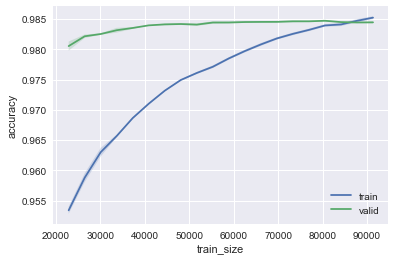

In [203]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')

**Сделайте выводы о том, помогут ли алгоритму новые размеченные данные при той же постановке задачи.**

На следующей неделе мы вспомним про линейные модели, обучаемые стохастическим градиентным спуском, и порадуемся тому, насколько быстрее они работают. Также сделаем первые (или не первые) посылки в [соревновании](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) Kaggle Inclass.